In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load and prepare data

In [2]:
from PIL import Image
import numpy as np
import cv2
from skimage import transform
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import shutil
import os


imsize = (128,96)

x1_train = []
for archivo in range(587):
    img = Image.open(os.path.join('dataset_sunrgbd/train_rgb',str(archivo)+'.jpg'))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    x1_train.append(np.asarray(img))
# x1_train = np.array(x1_train)
# x1_train = x1_train/255.0
# print(x1_train.shape)

# x1_test = []
for archivo in range(572):
    img = Image.open(os.path.join('dataset_sunrgbd/test_rgb',str(archivo)+'.jpg'))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    x1_train.append(np.asarray(img))
x1_train = np.array(x1_train)
x1_train = x1_train/255.0
print(x1_train.shape)

x2_train = []
for archivo in range(587):
    img = Image.open(os.path.join('dataset_sunrgbd/train_depth',str(archivo)+'.png'))
    img = cv2.resize(cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB), dsize=imsize)
#     img = cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB)
    x2_train.append(np.asarray(img))
# x2_train = np.array(x2_train)
# x2_train = x2_train/26000.0
# print(x2_train.shape)

# x2_test = []
for archivo in range(572):
    img = Image.open(os.path.join('dataset_sunrgbd/test_depth',str(archivo)+'.png'))
    img = cv2.resize(cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB), dsize=imsize)
#     img = cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB)
    x2_train.append(np.asarray(img))
x2_train = np.array(x2_train)
x2_train = x2_train/26000.0
print(x2_train.shape)

y_train = []
for archivo in range(587):
    img = np.load(os.path.join('dataset_sunrgbd/train_label',str(archivo)+'.npy'))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    for i in range(0,img.shape[0]-1):
        for j in range(0,img.shape[1]-1):
            if img[i,j]%1 != 0:
                img[i,j]=38
    y_train.append(img)
# y_train = np.array(y_train).astype('uint8')
# y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
# print(y_train.shape)

# y_test = []
for archivo in range(572):
    img = np.load(os.path.join('dataset_sunrgbd/test_label',str(archivo)+'.npy'))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    for i in range(0,img.shape[0]-1):
        for j in range(0,img.shape[1]-1):
            if img[i,j]%1 != 0:
                img[i,j]=38
    y_train.append(img)
y_train = np.array(y_train).astype('uint8')
y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
y_train = y_train[:,:,:,:38]
print(y_train.shape)

del img


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_sunrgbd/train_rgb\\0.jpg'

In [ ]:
from sklearn.model_selection import train_test_split

x = np.array(list(zip(x1_train[1:], x2_train[1:])))
del x1_train, x2_train

x_train, x_val, y_train, y_val = train_test_split(x,y_train[1:],test_size=0.3)
del x

x1_train, x2_train = x_train[:, 0], x_train[:, 1]
del x_train

x_test, x_val, y_test, y_val = train_test_split(x_val,y_val,test_size=0.5)

x1_test, x2_test = x_test[:, 0], x_test[:, 1]
x1_val, x2_val = x_val[:, 0], x_val[:, 1]

del x_test, x_val

In [ ]:
import matplotlib.pyplot as plt

def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

In [ ]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

for number in range(1):
    fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))
    ax = fig.add_subplot(1, 3, 1)
    plot_color(ax, x1_train[number])

    ax = fig.add_subplot(1, 3, 2)
    plot_depth(ax, x2_train[number])

    ax = fig.add_subplot(1, 3, 3)
    plot_label(ax, np.argmax(y_train[number],axis=-1))

    plt.show()

In [ ]:
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


x1_train = preprocess_input(x1_train)
x2_train = preprocess_input(x2_train)
x1_val = preprocess_input(x1_val)
x2_val = preprocess_input(x2_val)
x1_test = preprocess_input(x1_test)
x2_test = preprocess_input(x2_test)

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.02,
        zoom_range=[0.9, 1.25],
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode="nearest",
        seed=42)
val_datagen = ImageDataGenerator()

TypeError: __init__() got an unexpected keyword argument 'seed'

In [4]:
train_datagen.fit(x1_train)
val_datagen.fit(x1_val)

NameError: name 'train_datagen' is not defined

In [5]:
train = train_datagen.flow([x1_train, x2_train], y_train, batch_size=8)
validation = val_datagen.flow([x1_val, x2_val], y_val, batch_size=8)

NameError: name 'train_datagen' is not defined

# Create model

In [2]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm


sm.set_framework('tf.keras')
sm.framework()

pretrained_model_1 = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=30, activation='softmax', input_shape=(None, None, 3))
pretrained_model_1.summary()
for layer in pretrained_model_1.layers:
    layer._name += '_1'

Segmentation Models: using `keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
______________________________________________

In [3]:
pretrained_model_2 = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=30, activation='softmax', input_shape=(None, None, 3))
pretrained_model_2.summary()
for layer in pretrained_model_2.layers:
    layer._name += '_2'

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [4]:
#last layers add_ and add_31 for 34,50 add_32 and add_65 for 101
rgb_last = pretrained_model_1.get_layer('add_15_1')
depth_last = pretrained_model_2.get_layer('add_31_2')
print('model_1 layer output shape: ', rgb_last.output_shape)
print('model_2 layer output shape: ', depth_last.output_shape)
output_1 = rgb_last.output
output_2 = depth_last.output

# Middle layers unit6 for 34, 50 and unit23 for 101 relu2 for 34 and relu3 for 50, 101
rgb_stage_1 = pretrained_model_1.get_layer('stage1_unit3_relu2_1') 
depth_stage_1 = pretrained_model_2.get_layer('stage1_unit3_relu2_2')
rgb_stage_2 = pretrained_model_1.get_layer('stage2_unit4_relu2_1')
depth_stage_2 = pretrained_model_2.get_layer('stage2_unit4_relu2_2')
rgb_stage_3 = pretrained_model_1.get_layer('stage3_unit6_relu2_1')
depth_stage_3 = pretrained_model_2.get_layer('stage3_unit6_relu2_2')
rgb_stage_4 = pretrained_model_1.get_layer('stage4_unit3_relu2_1')
depth_stage_4 = pretrained_model_2.get_layer('stage4_unit3_relu2_2')

rgb_fusion_1 = rgb_stage_1.output
depth_fusion_1 = depth_stage_1.output
rgb_fusion_2 = rgb_stage_2.output
depth_fusion_2 = depth_stage_2.output
rgb_fusion_3 = rgb_stage_3.output
depth_fusion_3 = depth_stage_3.output
rgb_fusion_4 = rgb_stage_4.output
depth_fusion_4 = depth_stage_4.output

model_1 layer output shape:  (None, None, None, 512)
model_2 layer output shape:  (None, None, None, 512)


In [5]:
def rgbd_fusion(input_r,input_d,reshape_size,label):
    r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
    r = tf.keras.layers.Reshape((1,1,reshape_size))(r)
    r = tf.keras.layers.Conv2D(32,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
    r = tf.keras.layers.Conv2D(reshape_size,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
    m_1 = tf.keras.layers.Multiply()([input_r,r])
    
    d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
    d = tf.keras.layers.Reshape((1,1,reshape_size))(d)
    d = tf.keras.layers.Conv2D(32,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
    d = tf.keras.layers.Conv2D(reshape_size,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
    m_2 = tf.keras.layers.Multiply()([input_d,d])
    name = 'fusion' + label
    last = tf.keras.layers.Add(name=name)([m_1,m_2])
    
    return last

def decode_layer(input_de,input_ad,filters):
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(input_de)
    x = tf.keras.layers.Concatenate()([x,input_ad])
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x


def last_decode_layer(input_de,filters):
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(input_de)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

In [6]:
print(rgb_fusion_1.shape)
print(rgb_fusion_2.shape)
print(rgb_fusion_3.shape)
# print(rgb_fusion_4.shape)
print(output_1.shape)

(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 512)


In [7]:
fusion_1 = rgbd_fusion(rgb_fusion_1,depth_fusion_1,64,'_1')
print(fusion_1.shape)
fusion_2 = rgbd_fusion(rgb_fusion_2,depth_fusion_2,128,'_2')
print(fusion_2.shape)
fusion_3 = rgbd_fusion(rgb_fusion_3,depth_fusion_3,256,'_3')
print(fusion_3.shape)
fusion_4 = rgbd_fusion(rgb_fusion_4,depth_fusion_4,512,'_4')
print(fusion_4.shape)
fusion_last = rgbd_fusion(output_1, output_2,512,'_last') #512 for 34 and 2048 for 101
print(fusion_last.shape)

(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 512)
(None, None, None, 512)


In [8]:
xr = decode_layer(fusion_last,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_4),512)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_3),256)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_2),256)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_1),128)
xr = last_decode_layer(xr,64)

xr = tf.keras.layers.Conv2D(38, kernel_size=(1, 1), activation='softmax', padding='same', name='last_layer')(xr)

model = tf.keras.Model(inputs=[pretrained_model_1.input, pretrained_model_2.input], outputs=xr, name='myModel')
# encoder_fusion = tf.keras.Model(inputs=[pretrained_model_1.input, pretrained_model_2.input], outputs=fusion)
model.summary()

Model: "myModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_1 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
data_2 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data_1 (BatchNormalization)  (None, None, None, 3 9           data_1[0][0]                     
__________________________________________________________________________________________________
bn_data_2 (BatchNormalization)  (None, None, None, 3 9           data_2[0][0]                     
____________________________________________________________________________________________

conv2d_4 (Conv2D)               (None, 1, 1, 32)     4128        reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1, 1, 32)     4128        reshape_3[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, None, None, 2 590080      tf.nn.relu_2[0][0]               
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 1, 1, 128)    4224        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 1, 1, 128)    4224        conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [9]:
stage_fusion = model.get_layer('last_layer')
print(' layer output shape: ', stage_fusion.output_shape)

 layer output shape:  (None, None, None, 38)


# Training the model

## Plot Training accuracy and loss

In [18]:
import matplotlib.pyplot as plt

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

## metrics

In [19]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

## callbacks

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
weight_path="{}_best_weights.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=10, 
                                   verbose=1, min_delta=0.0001, cooldown=2, min_lr=1e-7)

def step_decay(epoch):
    initial_lrate = 1e-5
#     if epoch >= 5:
#         initial_lrate = 5e-5
#     if epoch >= 10:
#         initial_lrate = 2.5e-5
#     if epoch >= 30:
#         initial_lrate = 1e-6
#     if epoch >= 60:
#         initial_lrate = 5e-6
#     print('lr is: ', initial_lrate)
    return initial_lrate
lrate = LearningRateScheduler(step_decay)

early = EarlyStopping(monitor="val_loss",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, lrate]

## Model fit

In [24]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import precision, iou_score

opt = tf.keras.optimizers.Adam(learning_rate=0.0001,
                               beta_1=0.9,
                               beta_2=0.999,
                               epsilon=1e-07,
                               amsgrad=False,
                               name="Adam",
)


model.compile(optimizer="Adam", loss='categorical_crossentropy', 
              metrics=[dice_coef, 
                       'accuracy', 
                       true_positive_rate, 
                       iou_score
                      ])

history = model.fit(train, epochs=1000, verbose=1, validation_data=validation, callbacks=callbacks_list)

Epoch 1/1000
102/102 [==============================] - 109s 877ms/step - loss: 3.7960 - dice_coef: 0.0123 - accuracy: 0.1000 - true_positive_rate: 0.0064 - iou_score: 0.0056 - val_loss: 3.5669 - val_dice_coef: 0.0000e+00 - val_accuracy: 0.2205 - val_true_positive_rate: 0.0000e+00 - val_iou_score: 0.0045

Epoch 00001: val_loss improved from inf to 3.56688, saving model to seg_model_2_best_weights.hdf5
Epoch 2/1000
102/102 [==============================] - 84s 828ms/step - loss: 3.3477 - dice_coef: 0.0468 - accuracy: 0.2039 - true_positive_rate: 0.0246 - iou_score: 0.0094 - val_loss: 3.5655 - val_dice_coef: 0.0000e+00 - val_accuracy: 0.2205 - val_true_positive_rate: 0.0000e+00 - val_iou_score: 0.0046

Epoch 00002: val_loss improved from 3.56688 to 3.56555, saving model to seg_model_2_best_weights.hdf5
Epoch 3/1000
102/102 [==============================] - 80s 788ms/step - loss: 2.9819 - dice_coef: 0.1096 - accuracy: 0.3112 - true_positive_rate: 0.0595 - iou_score: 0.0146 - val_loss: 3


Epoch 00038: val_loss improved from 1.97638 to 1.97085, saving model to seg_model_2_best_weights.hdf5
Epoch 39/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
102/102 [==============================] - 80s 783ms/step - loss: 1.9847 - dice_coef: 0.3669 - accuracy: 0.5356 - true_positive_rate: 0.2392 - iou_score: 0.0335 - val_loss: 1.9699 - val_dice_coef: 0.4195 - val_accuracy: 0.5454 - val_true_positive_rate: 0.2868 - val_iou_score: 0.0369

Epoch 00039: val_loss improved from 1.97085 to 1.96987, saving model to seg_model_2_best_weights.hdf5
Epoch 40/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
102/102 [==============================] - 80s 784ms/step - loss: 1.9833 - dice_coef: 0.3694 - accuracy: 0.5374 - true_positive_rate: 0.2417 - iou_score: 0.0336 - val_loss: 1.9626 - val_dice_coef: 0.4231 - val_accuracy: 0.5455 - val_true_positive_rate: 0.2907 - val_iou_score: 0.0371

Epoch 00040: val_loss improved from 1.96987 to 1.96260, saving model to seg_model_2_b

Epoch 57/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
102/102 [==============================] - 80s 782ms/step - loss: 1.9234 - dice_coef: 0.3844 - accuracy: 0.5441 - true_positive_rate: 0.2548 - iou_score: 0.0348 - val_loss: 1.9147 - val_dice_coef: 0.4328 - val_accuracy: 0.5514 - val_true_positive_rate: 0.2999 - val_iou_score: 0.0378

Epoch 00057: val_loss improved from 1.91830 to 1.91467, saving model to seg_model_2_best_weights.hdf5
Epoch 58/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
102/102 [==============================] - 80s 780ms/step - loss: 1.9160 - dice_coef: 0.3838 - accuracy: 0.5447 - true_positive_rate: 0.2543 - iou_score: 0.0349 - val_loss: 1.9099 - val_dice_coef: 0.4383 - val_accuracy: 0.5514 - val_true_positive_rate: 0.3052 - val_iou_score: 0.0382

Epoch 00058: val_loss improved from 1.91467 to 1.90992, saving model to seg_model_2_best_weights.hdf5
Epoch 59/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
102/102 [=======


Epoch 00091: val_loss improved from 1.64279 to 1.63764, saving model to seg_model_2_best_weights.hdf5
Epoch 92/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 785ms/step - loss: 1.5610 - dice_coef: 0.4890 - accuracy: 0.5827 - true_positive_rate: 0.3579 - iou_score: 0.0438 - val_loss: 1.6233 - val_dice_coef: 0.5149 - val_accuracy: 0.5732 - val_true_positive_rate: 0.3912 - val_iou_score: 0.0458

Epoch 00092: val_loss improved from 1.63764 to 1.62329, saving model to seg_model_2_best_weights.hdf5
Epoch 93/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 785ms/step - loss: 1.5586 - dice_coef: 0.4915 - accuracy: 0.5817 - true_positive_rate: 0.3597 - iou_score: 0.0440 - val_loss: 1.6162 - val_dice_coef: 0.5238 - val_accuracy: 0.5729 - val_true_positive_rate: 0.4037 - val_iou_score: 0.0472

Epoch 00093: val_loss improved from 1.62329 to 1.

102/102 [==============================] - 80s 785ms/step - loss: 1.4467 - dice_coef: 0.5230 - accuracy: 0.5965 - true_positive_rate: 0.3943 - iou_score: 0.0472 - val_loss: 1.5506 - val_dice_coef: 0.5396 - val_accuracy: 0.5790 - val_true_positive_rate: 0.4262 - val_iou_score: 0.0499

Epoch 00109: val_loss did not improve from 1.53967
Epoch 110/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 785ms/step - loss: 1.4473 - dice_coef: 0.5246 - accuracy: 0.5956 - true_positive_rate: 0.3961 - iou_score: 0.0474 - val_loss: 1.5415 - val_dice_coef: 0.5378 - val_accuracy: 0.5777 - val_true_positive_rate: 0.4234 - val_iou_score: 0.0494

Epoch 00110: val_loss did not improve from 1.53967
Epoch 111/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 786ms/step - loss: 1.4344 - dice_coef: 0.5274 - accuracy: 0.5982 - true_positive_rate: 0.3993 - iou_sco

102/102 [==============================] - 80s 782ms/step - loss: 1.2667 - dice_coef: 0.5743 - accuracy: 0.6246 - true_positive_rate: 0.4539 - iou_score: 0.0544 - val_loss: 1.4385 - val_dice_coef: 0.5569 - val_accuracy: 0.5890 - val_true_positive_rate: 0.4526 - val_iou_score: 0.0528

Epoch 00145: val_loss improved from 1.44441 to 1.43853, saving model to seg_model_2_best_weights.hdf5
Epoch 146/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 782ms/step - loss: 1.2670 - dice_coef: 0.5766 - accuracy: 0.6251 - true_positive_rate: 0.4570 - iou_score: 0.0545 - val_loss: 1.4409 - val_dice_coef: 0.5554 - val_accuracy: 0.5891 - val_true_positive_rate: 0.4499 - val_iou_score: 0.0537

Epoch 00146: val_loss did not improve from 1.43853
Epoch 147/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 782ms/step - loss: 1.2632 - dice_coef: 0.5752 - accu


Epoch 00163: val_loss improved from 1.40846 to 1.40484, saving model to seg_model_2_best_weights.hdf5
Epoch 164/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 783ms/step - loss: 1.2175 - dice_coef: 0.5908 - accuracy: 0.6340 - true_positive_rate: 0.4759 - iou_score: 0.0565 - val_loss: 1.4080 - val_dice_coef: 0.5671 - val_accuracy: 0.5917 - val_true_positive_rate: 0.4704 - val_iou_score: 0.0553

Epoch 00164: val_loss did not improve from 1.40484
Epoch 165/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 783ms/step - loss: 1.2082 - dice_coef: 0.5914 - accuracy: 0.6356 - true_positive_rate: 0.4753 - iou_score: 0.0567 - val_loss: 1.4050 - val_dice_coef: 0.5662 - val_accuracy: 0.5915 - val_true_positive_rate: 0.4681 - val_iou_score: 0.0549

Epoch 00165: val_loss did not improve from 1.40484
Epoch 166/1000
New lr is:  5e-06
New lr is:  2.

102/102 [==============================] - 80s 784ms/step - loss: 1.0987 - dice_coef: 0.6311 - accuracy: 0.6592 - true_positive_rate: 0.5237 - iou_score: 0.0630 - val_loss: 1.3766 - val_dice_coef: 0.5750 - val_accuracy: 0.5943 - val_true_positive_rate: 0.4861 - val_iou_score: 0.0574

Epoch 00201: val_loss improved from 1.37707 to 1.37660, saving model to seg_model_2_best_weights.hdf5
Epoch 202/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 784ms/step - loss: 1.0972 - dice_coef: 0.6299 - accuracy: 0.6580 - true_positive_rate: 0.5218 - iou_score: 0.0633 - val_loss: 1.3719 - val_dice_coef: 0.5764 - val_accuracy: 0.5957 - val_true_positive_rate: 0.4868 - val_iou_score: 0.0573

Epoch 00202: val_loss improved from 1.37660 to 1.37186, saving model to seg_model_2_best_weights.hdf5
Epoch 203/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 7

102/102 [==============================] - 80s 784ms/step - loss: 1.0609 - dice_coef: 0.6416 - accuracy: 0.6684 - true_positive_rate: 0.5376 - iou_score: 0.0655 - val_loss: 1.3713 - val_dice_coef: 0.5780 - val_accuracy: 0.5946 - val_true_positive_rate: 0.4931 - val_iou_score: 0.0579

Epoch 00220: val_loss did not improve from 1.36630
Epoch 221/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 783ms/step - loss: 1.0574 - dice_coef: 0.6426 - accuracy: 0.6694 - true_positive_rate: 0.5380 - iou_score: 0.0659 - val_loss: 1.3751 - val_dice_coef: 0.5750 - val_accuracy: 0.5948 - val_true_positive_rate: 0.4909 - val_iou_score: 0.0588

Epoch 00221: val_loss did not improve from 1.36630
Epoch 222/1000
New lr is:  5e-06
New lr is:  2.5e-06
New lr is:  1e-06
New lr is:  5e-06
102/102 [==============================] - 80s 784ms/step - loss: 1.0599 - dice_coef: 0.6427 - accuracy: 0.6685 - true_positive_rate: 0.5389 - iou_sco

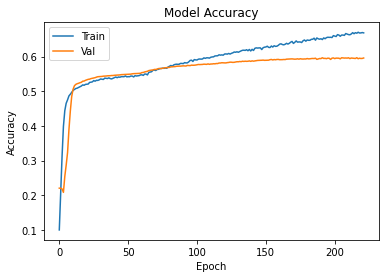

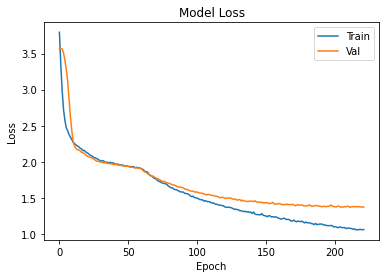

In [25]:
plot_acc(history)
plot_loss(history)

In [27]:
score = model.evaluate([x1_test,x2_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# # Para pasar la segmentacion a imagen
y_pred = model.predict([x1_test,x2_test])
y_classes = np.asarray([np.argmax(y, axis=-1) for y in y_pred])
label = np.asarray([np.argmax(y, axis=-1) for y in y_test])

In [ ]:
number = 3

for i in range (number):
    fig = plt.figure("Labeled Dataset Sample", figsize=(32, 10))
    ax = fig.add_subplot(1, 4, 1)
    plot_color(ax, x1_test[i])
    
    ax = fig.add_subplot(1, 4, 2)
    plot_depth(ax, x2_test[i])

    ax = fig.add_subplot(1, 4, 3)
    plot_label(ax, label[i])

    ax = fig.add_subplot(1, 4, 4)
    plot_label(ax, y_classes[i])

    plt.show()

# Fine tunning

In [ ]:
# release all layers for training
# set all layers trainable and recompile model
for layer in model.layers:
    layer.trainable=True 

In [ ]:
# continue training
history = model.fit(train, epochs=100, verbose=1, validation_data=validation, callbacks=callbacks_list)

In [ ]:
score = model.evaluate([x1_test,x2_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])